### RNN vs. LSTM

In [1]:
# chap05/train.py
import sys
sys.path.append('C:/Users/KimDongyoung/Desktop/Github/my_git/mygit/DEEPLEARNING/밑바닥부터시작하는딥러닝2')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from ptb import load_data
from ch05.simple_rnnlm import SimpleRnnlm
from ch06.rnnlm import Rnnlm
import numpy as np
import matplotlib.pyplot as plt
from common.util import eval_perplexity
import time
from common.util import clip_grads

In [ ]:
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x

class Embedding:
    def __init__(self, W):
        self.params = [W] # 가중치 W를 인스턴스 변수 params에 리스트로 저장
        self.grads = [np.zeros_like(W)] # W와 형상이 같은 행렬을 하나 준비, 0으로 초기화
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx] # W의 idx번째 행을 추출
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout) # dW의 self.idx번째 행에 dout을 더함
        return None
    
class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        self.out = softmax(x)
        return self.out

    def backward(self, dout):
        dx = self.out * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.out * sumdx
        return dx

In [ ]:
# Time Embedding
class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W

    def forward(self, xs):
        N, T = xs.shape # N은 미니배치 크기, T는 시계열 데이터의 길이, 하나의 데이터 당 T개의 단어가 들어있음
        V, D = self.W.shape # V는 어휘 수, D는 단어 벡터의 차원 수 

        out = np.empty((N, T, D), dtype='f') # 출력 데이터 저장용 배열
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, D = dout.shape

        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]

        self.grads[0][...] = grad
        return None

# RNN
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

# Time RNN
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None

# Tiem Affine
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params

        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx

# Time Softmax with Loss
class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 정답 레이블이 원핫 벡터인 경우
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)

        # 배치용과 시계열용을 정리(reshape)
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_label에 해당하는 데이터는 손실을 0으로 설정
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_labelㅇㅔ 해당하는 데이터는 기울기를 0으로 설정

        dx = dx.reshape((N, T, V))

        return dx


In [ ]:
class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 가중치 초기화 (Xavier initialization)
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b),
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()

In [34]:
def remove_duplicate(params, grads):
    '''
    매개변수 배열 중 중복되는 가중치를 하나로 모아
    그 가중치에 대응하는 기울기를 더한다.
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 가중치 공유 시
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 경사를 더함
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 가중치를 전치행렬로 공유하는 경우(weight tying)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads


In [36]:
class RnnlmTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.time_idx = None
        self.ppl_list = None
        self.eval_interval = None
        self.current_epoch = 0
        self.epoch_list = []  # epoch_list 초기화

    def get_batch(self, x, t, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')

        data_size = len(x)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]  # 배치에서 각 샘플을 읽기 시작하는 위치

        for time in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, time] = x[(offset + self.time_idx) % data_size]
                batch_t[i, time] = t[(offset + self.time_idx) % data_size]
            self.time_idx += 1
        return batch_x, batch_t

    def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35,
            max_grad=None, eval_interval=100):
        data_size = len(xs)
        max_iters = data_size // (batch_size * time_size)
        self.time_idx = 0
        self.ppl_list = []
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            for iters in range(max_iters):
                batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)

                # 기울기를 구해 매개변수 갱신
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 퍼플렉서티 평가
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    ppl = np.exp(total_loss / loss_count)
                    elapsed_time = time.time() - start_time
                    print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 퍼플렉서티 %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, ppl))
                    self.ppl_list.append(float(ppl))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = np.arange(len(self.ppl_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.ppl_list, label='train')
        plt.xlabel('Iteration (x' + str(self.eval_interval) + ')')
        plt.ylabel('Perplexity')
        plt.show()

### RNN 

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 10020.10
| 에폭 1 |  반복 101 / 1327 | 시간 15[s] | 퍼플렉서티 92221.30
| 에폭 1 |  반복 201 / 1327 | 시간 30[s] | 퍼플렉서티 18628.24
| 에폭 1 |  반복 301 / 1327 | 시간 45[s] | 퍼플렉서티 15950.53
| 에폭 1 |  반복 401 / 1327 | 시간 59[s] | 퍼플렉서티 13585.91
| 에폭 1 |  반복 501 / 1327 | 시간 73[s] | 퍼플렉서티 18337.09
| 에폭 1 |  반복 601 / 1327 | 시간 88[s] | 퍼플렉서티 17150.04
| 에폭 1 |  반복 701 / 1327 | 시간 102[s] | 퍼플렉서티 22600.47
| 에폭 1 |  반복 801 / 1327 | 시간 117[s] | 퍼플렉서티 22072.79
| 에폭 1 |  반복 901 / 1327 | 시간 132[s] | 퍼플렉서티 24914.54
| 에폭 1 |  반복 1001 / 1327 | 시간 147[s] | 퍼플렉서티 24855.87
| 에폭 1 |  반복 1101 / 1327 | 시간 162[s] | 퍼플렉서티 21314.92
| 에폭 1 |  반복 1201 / 1327 | 시간 176[s] | 퍼플렉서티 23138.83
| 에폭 1 |  반복 1301 / 1327 | 시간 191[s] | 퍼플렉서티 20983.39
| 에폭 2 |  반복 1 / 1327 | 시간 195[s] | 퍼플렉서티 25707.12
| 에폭 2 |  반복 101 / 1327 | 시간 209[s] | 퍼플렉서티 22934.81
| 에폭 2 |  반복 201 / 1327 | 시간 224[s] | 퍼플렉서티 24754.12
| 에폭 2 |  반복 301 / 1327 | 시간 239[s] | 퍼플렉서티 24257.89
| 에폭 2 |  반복 401 / 1327 | 시간 254[s] | 퍼플렉서티 25362.92
|

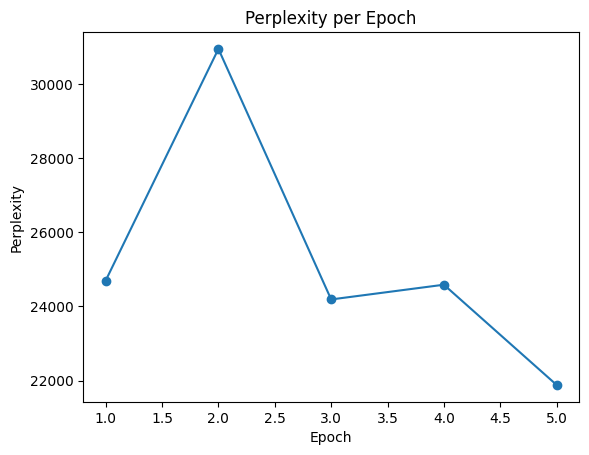

In [37]:
# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 5
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = load_data('train')
corpus_test, _, _ = load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad)
# trainer.plot()

# 에폭 당 퍼플렉서티 값 계산
epoch_perplexity = []
for i in range(max_epoch):
  start = i * (len(trainer.ppl_list) // max_epoch)
  end = (i + 1) * (len(trainer.ppl_list) // max_epoch)
  epoch_perplexity.append(np.mean(trainer.ppl_list[start:end]))

# 그래프 시각화
plt.plot(range(1, max_epoch + 1), epoch_perplexity, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity per Epoch')
plt.show()

### LSTM    

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 9996.68
| 에폭 1 |  반복 21 / 1327 | 시간 3[s] | 퍼플렉서티 2758.22
| 에폭 1 |  반복 41 / 1327 | 시간 7[s] | 퍼플렉서티 1223.92
| 에폭 1 |  반복 61 / 1327 | 시간 10[s] | 퍼플렉서티 942.81
| 에폭 1 |  반복 81 / 1327 | 시간 15[s] | 퍼플렉서티 748.19
| 에폭 1 |  반복 101 / 1327 | 시간 19[s] | 퍼플렉서티 615.76
| 에폭 1 |  반복 121 / 1327 | 시간 23[s] | 퍼플렉서티 615.62
| 에폭 1 |  반복 141 / 1327 | 시간 27[s] | 퍼플렉서티 588.50
| 에폭 1 |  반복 161 / 1327 | 시간 31[s] | 퍼플렉서티 553.17
| 에폭 1 |  반복 181 / 1327 | 시간 34[s] | 퍼플렉서티 556.79
| 에폭 1 |  반복 201 / 1327 | 시간 38[s] | 퍼플렉서티 486.74
| 에폭 1 |  반복 221 / 1327 | 시간 42[s] | 퍼플렉서티 467.98
| 에폭 1 |  반복 241 / 1327 | 시간 45[s] | 퍼플렉서티 426.09
| 에폭 1 |  반복 261 / 1327 | 시간 49[s] | 퍼플렉서티 449.73
| 에폭 1 |  반복 281 / 1327 | 시간 52[s] | 퍼플렉서티 444.65
| 에폭 1 |  반복 301 / 1327 | 시간 56[s] | 퍼플렉서티 382.20
| 에폭 1 |  반복 321 / 1327 | 시간 60[s] | 퍼플렉서티 333.16
| 에폭 1 |  반복 341 / 1327 | 시간 64[s] | 퍼플렉서티 388.41
| 에폭 1 |  반복 361 / 1327 | 시간 67[s] | 퍼플렉서티 397.83
| 에폭 1 |  반복 381 / 1327 | 시간 71[s] | 퍼플렉서티 324.53
| 에폭 1

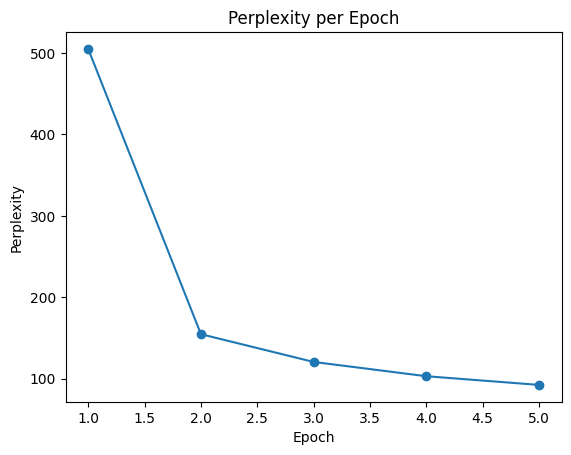

In [2]:
# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 5
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = load_data('train')
corpus_test, _, _ = load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad)
# trainer.plot()

# 에폭 당 퍼플렉서티 값 계산
epoch_perplexity = []
for i in range(max_epoch):
  start = i * (len(trainer.ppl_list) // max_epoch)
  end = (i + 1) * (len(trainer.ppl_list) // max_epoch)
  epoch_perplexity.append(np.mean(trainer.ppl_list[start:end]))

# 그래프 시각화
plt.plot(range(1, max_epoch + 1), epoch_perplexity, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity per Epoch')
plt.show()